In [7]:
#
library(lubridate)
library(RStoolbox)
library(raster)
library(ggplot2)
library(rgdal)
library(reshape2)
library(forecast)
library(mgcv)


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar

Loading required package: sp

rgdal: version: 1.5-16, (SVN revision 1050)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.1.2, released 2020/07/07
Path to GDAL shared files: /usr/share/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 7.1.1, September 1st, 2020, [PJ_VERSION: 711]
Path to PROJ shared files: /root/.local/share/proj:/usr/share/proj
PROJ CDN enabled: FALSE
Linking to sp version:1.4-2
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading rgdal.

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: nlme


Attaching package: 

In [8]:
#--------------------------------------------------------------------
# SCRIPT SETTINGS
# This section allows the user to choose specific indices among the F03

percorsoCartella <- "/home/data/PESARESI SIMONE/Pesaresi_et_al_2024/S2_Discrete_data" #directory contenente gli indici
metodo <- "bilinear" #scegliere tra vuoto (nessuna interpolazione) o bilinear (interpolazione bilineare) per la disaggregate
frequenza <- "WEEK" #scegliere tra WEEK o BEWEEK
delimiterFilePath <- "/home/data/PESARESI SIMONE/Pesaresi_et_al_2024/Shapefile/doy_week_beweek.txt"
shapefiledir <- "/home/data/PESARESI SIMONE/Pesaresi_et_al_2024/Shapefile/TD_CONERO.shp"


# Code to generate combinations according the formula F03
# BANDS TO USE
bands <- c('11','10','03') #'11','10','07','06','05','03','02'


# CREATE AN EMPTY MATRIX TO BE FILLED WITH combinations

combinazioni <- matrix(, nrow = 0, ncol = 3)

for (A in bands)
{
  for(B in bands)
  {
    for(C in bands)
    {
      if(B >= A || C>=A || C >= B){next}
      combinazioni <- rbind(combinazioni,c(A,B,C))
    }
  }
}
#add a column with double zero
combinazioni <- cbind(combinazioni,c("00"))



#--------------------------------------------------------------------
nomeCartella <- "F20"
cartella <- paste(percorsoCartella,nomeCartella,sep="/")
nomiFile <- list.files(cartella)

In [9]:
# Get the number of rows in the 'combinations' matrix
row <- nrow(combinazioni)

# Initialize an empty vector to store file paths
paths <- c("")

# Initialize a counter variable
i <- 0

# Loop through each 'nome' in 'nomiFile'
for (nome in nomiFile) {
  # Extract numerical combinations from the file name
  numcomb <- c(substring(nome, 8, 9), substring(nome, 11, 12), substring(nome, 14, 15), substring(nome, 17, 18))
  
  # Check if the numerical combinations match those in the 'combinazioni' matrix
  if (all(numcomb == combinazioni[row, c(1:4)])) {
    
    i <- i + 1
    # Build file paths for the matching files
    paths[i] <- paste(cartella, nome, sep = "/")
  }
}

# Create a raster stack using the generated file paths
mylayers <- stack(paths) 

# Load a shapefile and create a buffer
file.shape <- shapefiledir
pu <- shapefile(file.shape)
p <- buffer(pu, 30)

# Crop and mask the raster stack based on the buffer
mylayers.crop <- crop(mylayers, p) 
mylayers.mask <- mask(mylayers.crop, p)

# Convert raster data to a data frame of points
mylayers.point <- as.data.frame(rasterToPoints(mylayers.mask))
  d <- dim(mylayers.point)
  d1 <- d[1] 
  d2 <- d[2] 

# Extract dates and convert them to Day of Year (DOY)
nomi.date <- paste(substring(colnames(mylayers.point[, 3:d2]), 25, 28), 
                   substring(colnames(mylayers.point[, 3:d2]), 29, 30),
                   substring(colnames(mylayers.point[, 3:d2]), 31, 32), sep = "-")

DOY <- as.numeric(strftime(as.Date(nomi.date), "%j"))
DOY <- c('x', 'y', DOY)
colnames(mylayers.point) <- DOY 

# Order and process the data
dati <- mylayers.point[, 3:d2]
dati.coord <- mylayers.point[, 1:2]
dati.ordered <- dati[, order(ceiling(as.numeric(colnames(dati))))]
dati.ordered.t <- as.data.frame(t(dati.ordered))

# Split the column names to get Day of Year (DOY)
doy.sep <- colsplit(as.vector(rownames(dati.ordered.t)), "\\.", c(1:2))
dati.ordered.t$DOY <- as.numeric(doy.sep[, 1])

# Read a delimiter file and merge with the ordered data
file.365 <- delimiterFilePath
doy.week.beweek <- read.delim(file = file.365, row.names = 1, header = TRUE, sep = "\t", dec = ".", check.names = FALSE)
dati.doy.week.beweek <- merge(doy.week.beweek, dati.ordered.t, all.x = TRUE)


In [10]:
# Apply the tsclean function  to values organized by Day of Year (DoY) to remove outliers
clean2 <- function(x) { tsclean(x, replace.missing = FALSE, lambda = NULL) } # The tsclean function from forecast
dati.clean.doy <- sapply(dati.doy.week.beweek, FUN = clean2)

#----------------------------------------------------------------

# Define the variable t.aggr as 'DOY' (fairly slow process)
t.aggr <- 'DOY' 
# Aggregate the cleaned data by Day of Year (DoY)
dati.aggr <- aggregate(dati.clean.doy, by = list(as.numeric(dati.clean.doy[, t.aggr])), FUN = mean, na.rm = TRUE)

# Reassign t.aggr to the frequency variable ('WEEK' or 'BEWEEK')
t.aggr <- frequenza 
# Further aggregate the data by the specified frequency ('WEEK' or 'BEWEEK')
dati.aggr <- aggregate(dati.aggr, by = list(as.numeric(dati.aggr[, t.aggr])), FUN = mean, na.rm = TRUE)

# Select only the data columns from the sixth column to the end, excluding the 'group' and 'tempo' columns
dati.aggr <- dati.aggr[, 6:(d1 + 5)]


In [11]:
# Combine coordinate data and aggregated data
dati.aggr.point <- cbind(dati.coord, t(dati.aggr))

# Create a raster object from the combined data
ra <- rasterFromXYZ(dati.aggr.point)

# Extract values from the raster for the specified shapefile (pu) using bilinear interpolation
aggr.pu <- extract(ra, pu, method = 'bilinear')


Warning message in matrix(values, nrow = ncell(x), ncol = nlayers(x)):
“data length [5665772] is not a sub-multiple or multiple of the number of rows [108958]”


In [12]:
#----------------------------------------------------------------
  
# Definition of time points
tempi <- 1:52

# Definition of the GAM (Generalized Additive Model) fitting function with default setting
f1 <- function(x) {
  return(predict(gam(as.vector(x) ~ s(tempi, bs = c("cc"), k = -1), na.action = na.exclude), data.frame(tempi = seq(1, max(tempi), 1), se = FALSE)))
}

# Applying the fitting function to aggregated data
dati.tempi.fit <- apply(dati.aggr, MARGIN = 2, f1)

# Creating a dataframe with coordinates and fitted values at time points
dati.tempi.fit.point <- cbind(dati.coord, t(dati.tempi.fit))
d.c <- dati.coord
coordinates(dati.tempi.fit.point) <- ~x+y

# Creating a raster from fitted points and rasterizing based on existing geometries
r <- mylayers.mask
r <- rasterize(dati.tempi.fit.point, r)

# Disaggregating the raster
rd <- disaggregate(r, fact = c(1, 1), method = metodo) # c(1,1) for Sentinel, c(3,3) for Landsat
  
#------------------------------------------------------------------

# Extracting disaggregated data for shapefile geometries
dati.pu <- extract(rd, pu, method = 'bilinear')
dati.tempi.fit.p <- dati.pu[, 2:(max(tempi) + 1)]


#this following code produce the same files contained in the time series folder

# Saving point time series (commented)
# nomeOutput <- paste("F03", combinazioni[riga, 1], combinazioni[riga, 2], combinazioni[riga, 3], combinazioni[riga, 4], "10", "BIL.txt", sep = "_")
# dati.tempi.fit.p <- cbind(pu@data$X, pu@data$Y, pu@data$CLASS, pu@data$CLASS1, dati.tempi.fit.p)
# colnames(dati.tempi.fit.p)[1:4] <- c("X", "Y", "CLASS", "CLASS1")
# write.table(t(dati.tempi.fit.p), nomeOutput)


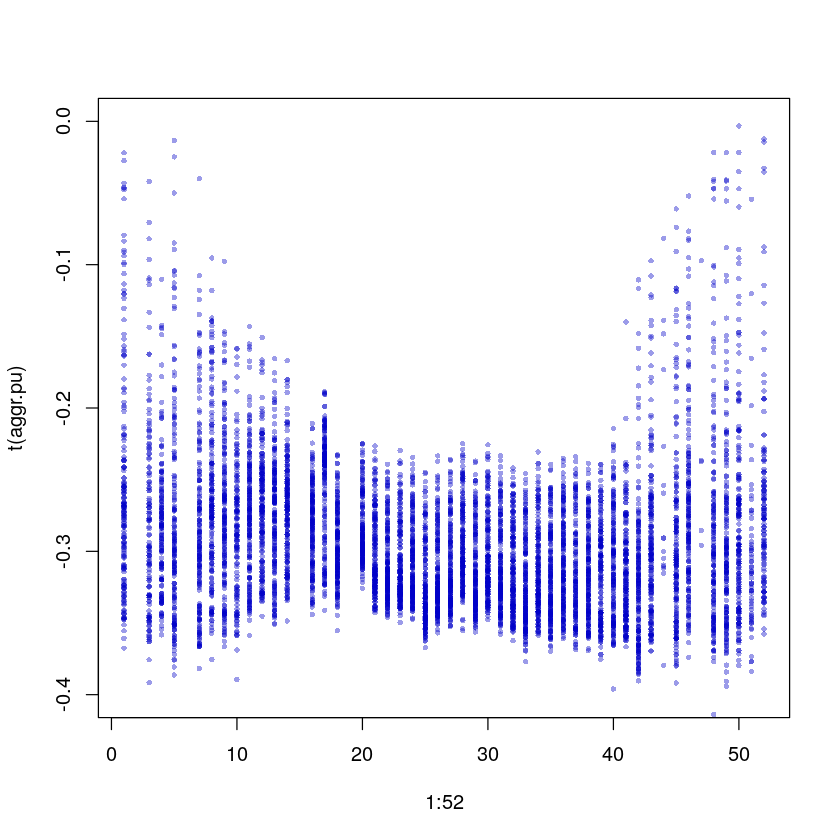

In [19]:
# Plotting discrete weekly data without outliers
matplot(1:52, t(aggr.pu), pch = 16, cex = 0.6, col = rgb(0, 0, 200, 100, max = 255), ylim = c(-0.4, 0))


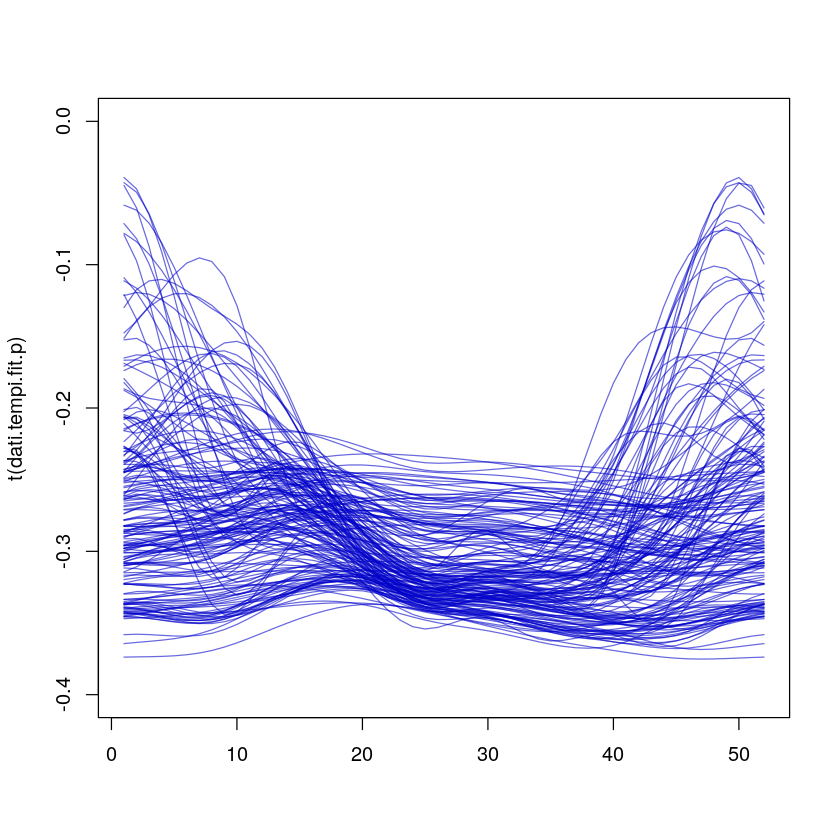

In [17]:
# Plotting functions obtained from GAM using discrete weekly data
matplot(t(dati.tempi.fit.p), type = 'l', col = rgb(0, 0, 200, 100, max = 255), lty = 1, ylim = c(-0.4, 0))
